In [1]:
!pip install contractions
!pip install nltk

In [2]:
import os
import glob
import re

import contractions
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from wordcloud import WordCloud, STOPWORDS


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')


/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to /Users/jerry/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/jerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jerry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploratory Data Analysis

### Reading in the positive and negative reviews


In [47]:
pos_file_path = 'data/pos/*.txt'  # Adjust this path to your specific directory
neg_file_path = 'data/neg/*.txt'

def get_data(file_path):
    files = glob.glob(file_path)
    df = pd.DataFrame(columns=['FileName', 'Content'])
    for file in files:
        # Extracting file name
        file_name = os.path.basename(file)
        # Reading file content
        with open(file, 'r', encoding='utf-8') as file_open:
            content = file_open.read()
        df = df.append({'FileName': file_name, 'Content': content}, ignore_index=True)
    return df

In [48]:
pos_unclean_df = get_data(pos_file_path)
neg_unclean_df = get_data(neg_file_path)

In [49]:
pos_unclean_df.head()

,FileName,Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and..."
1,12390_8.txt,This movie looked like a classic in the cheesy...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac..."
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave..."


In [50]:
neg_unclean_df.head()

,FileName,Content
0,3314_4.txt,Stan Laurel and Oliver Hardy are the most famo...
1,17112_1.txt,"I saw this movie a few years ago, and man I ne..."
2,3008_1.txt,I watched this film few times and all i can sa...
3,17951_1.txt,From reading the back of the box my first thou...
4,9487_1.txt,This is a film of immense appeal to a relative...


### Generate rating from the txt file name

In [56]:
def extract_rating_from_filename(filename):
    parts = filename.split("_")
    rating = parts[1].split(".")[0]
    return int(rating)

In [57]:
pos_unclean_df['rating'] = pos_unclean_df['FileName'].apply(lambda z: extract_rating_from_filename(z))
pos_unclean_df.head()

,FileName,Content,rating
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9
1,12390_8.txt,This movie looked like a classic in the cheesy...,8
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8


In [58]:
#Check unique ratings
pos_ratings = pos_unclean_df['rating'].unique()
print(pos_ratings)

[ 9  8  7 10]


In [60]:
neg_unclean_df['rating'] = neg_unclean_df['FileName'].apply(lambda z: extract_rating_from_filename(z))
neg_unclean_df.head()

,FileName,Content,rating
0,3314_4.txt,Stan Laurel and Oliver Hardy are the most famo...,4
1,17112_1.txt,"I saw this movie a few years ago, and man I ne...",1
2,3008_1.txt,I watched this film few times and all i can sa...,1
3,17951_1.txt,From reading the back of the box my first thou...,1
4,9487_1.txt,This is a film of immense appeal to a relative...,1


In [61]:
neg_ratings = neg_unclean_df['rating'].unique()
print(neg_ratings)

[4 1 3 2]


In [62]:
pos_unclean_df.head()

,FileName,Content,rating
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9
1,12390_8.txt,This movie looked like a classic in the cheesy...,8
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8


In [63]:
neg_unclean_df.head()

,FileName,Content,rating
0,3314_4.txt,Stan Laurel and Oliver Hardy are the most famo...,4
1,17112_1.txt,"I saw this movie a few years ago, and man I ne...",1
2,3008_1.txt,I watched this film few times and all i can sa...,1
3,17951_1.txt,From reading the back of the box my first thou...,1
4,9487_1.txt,This is a film of immense appeal to a relative...,1


### Cleaning Positive dataset


In [64]:
#Only uncomment when need to generate csv, but dont need already
#pos_unclean_df.to_csv("pos.csv")
#neg_unclean_df.to_csv("neg.csv")

In [65]:
#specify this to your directory. if using collab, just "pos.csv"
file_path = "data/pos.csv"
pos_unclean_df = pd.read_csv(file_path)
pos_unclean_df.drop(pos_unclean_df.columns[0], axis=1, inplace=True)
pos_unclean_df.head()

,FileName,Content,rating
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9
1,12390_8.txt,This movie looked like a classic in the cheesy...,8
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8


In [66]:
pos_unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  25000 non-null  object
 1   Content   25000 non-null  object
 2   rating    25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [67]:
pos_unclean_df.describe()

,rating
count,25000.000000
mean,5.267480
std,3.461643
min,1.000000
25%,1.000000
50%,7.000000
75%,8.000000
max,9.000000


In [68]:
before =  pos_unclean_df.shape[0]
pos_unclean_df.drop_duplicates(inplace=True)
after = pos_unclean_df.shape[0]

print("No. of rows removed :", before - after)

No. of rows removed : 0


Remove HTML syntaxes

In [69]:
HTML_TAG_PATTERN = re.compile(r'<[^>]+>', re.IGNORECASE)

def remove_html(data):
    # Remove HTML tags
    data = HTML_TAG_PATTERN.sub('', data)
    return data

In [70]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_html(z))


In [71]:
pos_unclean_df.head(10)

,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,"I just watched ""return from lonesome dove"" and..."
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,This movie looked like a classic in the cheesy...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,Jay Chou plays an orphan raised in a kung fu s...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,"Ooverall, the movie was fairly good, a good ac..."
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,"This movie is fun to watch. If you liked ""Dave..."
5,10186_10.txt,I loved this movie. In fact I loved being an a...,1,I loved this movie. In fact I loved being an a...
6,22540_10.txt,Andaz Apna Apna is my favorite comedy movie of...,1,Andaz Apna Apna is my favorite comedy movie of...
7,147_10.txt,"In the very first episode of Friends, which ai...",1,"In the very first episode of Friends, which ai..."
8,3092_10.txt,"This, like Murder She Wrote, is one of those s...",1,"This, like Murder She Wrote, is one of those s..."
9,15251_8.txt,Pretty good movie about a man and his wife who...,8,Pretty good movie about a man and his wife who...


Remove URL Data

In [72]:
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

In [73]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_url(z))


Remove Emojis

In [74]:
def remove_emoji(data):
    # Extended emoji range to include more characters, including newer ones and skin tone modifiers
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # additional symbols
                               u"\U000024C2-\U0001F251"  # additional symbols
                               u"\U0001F900-\U0001F9FF"  # supplementary symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # chess symbols, extended pictographs
                               u"\U0001FA70-\U0001FAFF"  # more extended pictographs
                               u"\U00002600-\U000026FF"  # miscellaneous symbols
                               u"\U00002700-\U000027BF"  # dingbats
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U000E0020-\U000E007F"  # Tag characters for emoji
                               "]+", flags=re.UNICODE)
    data = emoji_pattern.sub(r'', data)
    return data

In [75]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_emoji(z))

Lower Case text

In [76]:
def lowercase(text):
  word_list = str(text).split(' ')
  return ' '.join([word.lower() for word in word_list])

In [77]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: lowercase(z))

In [78]:
pos_unclean_df.head()

,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,"i just watched ""return from lonesome dove"" and..."
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,this movie looked like a classic in the cheesy...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,jay chou plays an orphan raised in a kung fu s...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,"ooverall, the movie was fairly good, a good ac..."
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,"this movie is fun to watch. if you liked ""dave..."


Remove Contractions

In [79]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Cleaned_Content'].apply(contractions.fix)

In [80]:
pos_unclean_df.head()

,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,"i just watched ""return from lonesome dove"" and..."
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,this movie looked like a classic in the cheesy...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,jay chou plays an orphan raised in a kung fu s...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,"ooverall, the movie was fairly good, a good ac..."
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,"this movie is fun to watch. if you liked ""dave..."


Remove punctuations

In [81]:
def remove_punctuation(text):
    punctuation_pattern = re.compile(r'[^\w\s]')
    
    clean_text = punctuation_pattern.sub('', text)
    return clean_text

In [82]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Cleaned_Content'].apply(lambda z: remove_punctuation(z))

In [83]:
pos_unclean_df.head(30)

,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,i just watched return from lonesome dove and i...
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,this movie looked like a classic in the cheesy...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,jay chou plays an orphan raised in a kung fu s...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,ooverall the movie was fairly good a good acti...
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,this movie is fun to watch if you liked dave w...
5,10186_10.txt,I loved this movie. In fact I loved being an a...,1,i loved this movie in fact i loved being an ac...
6,22540_10.txt,Andaz Apna Apna is my favorite comedy movie of...,1,andaz apna apna is my favorite comedy movie of...
7,147_10.txt,"In the very first episode of Friends, which ai...",1,in the very first episode of friends which air...
8,3092_10.txt,"This, like Murder She Wrote, is one of those s...",1,this like murder she wrote is one of those sho...
9,15251_8.txt,Pretty good movie about a man and his wife who...,8,pretty good movie about a man and his wife who...


Data has been cleaned, now make a copy of it in pos_cleaned_df

In [84]:
pos_cleaned_df = pos_unclean_df

Tokenization

In [85]:
tokenizer = TweetTokenizer()
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(tokenizer.tokenize)

Remove Stopwords

In [86]:
stop_words = set(stopwords.words('english'))

In [87]:
#Come up with a set of words that we find are useful in determining sentiment from the stopwords
#keep_in_tokens = [Insert list of words to keep here]

def filter_tokens(tokens):
    return [token for token in tokens if token not in stop_words]

In [88]:
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(filter_tokens)

Lemmatization

In [89]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [90]:
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(lemmatize_tokens)

In [91]:
pos_cleaned_df.head(10)

,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,watched return lonesome dove good seen lot neg...
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,movie looked like classic cheesy 80 slasher ge...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,jay chou play orphan raised kung fu school kic...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,ooverall movie fairly good good action plot fa...
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,movie fun watch liked dave kevin klein get kic...
5,10186_10.txt,I loved this movie. In fact I loved being an a...,1,loved movie fact loved actress movie iwas feat...
6,22540_10.txt,Andaz Apna Apna is my favorite comedy movie of...,1,andaz apna apna favorite comedy movie timeboth...
7,147_10.txt,"In the very first episode of Friends, which ai...",1,first episode friend aired 22 sept 1994 one mo...
8,3092_10.txt,"This, like Murder She Wrote, is one of those s...",1,like murder wrote one show stressful day schoo...
9,15251_8.txt,Pretty good movie about a man and his wife who...,8,pretty good movie man wife get caught murder p...


In [92]:
temp_df = pos_cleaned_df[['Cleaned_Content', 'rating']].copy()
temp_df.rename(columns = {'Cleaned_Content': 'Text', 'rating': "Sentiment"}, inplace=True)
temp_df.head()

,Text,Sentiment
0,watched return lonesome dove good seen lot neg...,9
1,movie looked like classic cheesy 80 slasher ge...,8
2,jay chou play orphan raised kung fu school kic...,8
3,ooverall movie fairly good good action plot fa...,7
4,movie fun watch liked dave kevin klein get kic...,8


Generate the word cloud to visualise frequency of words

In [93]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

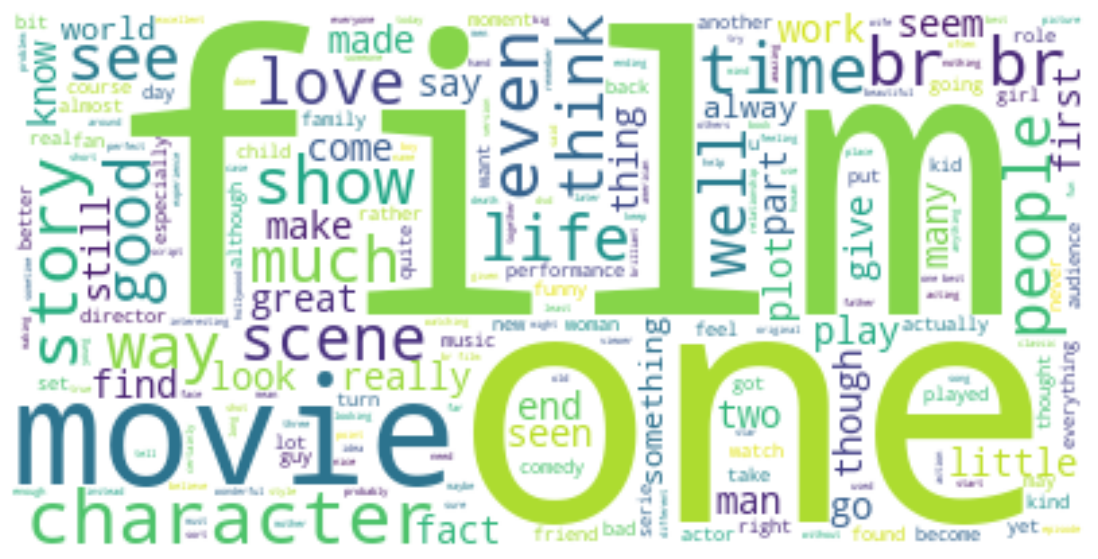

In [94]:
pos = temp_df.Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)